# A5 Extension Plan

In [1]:
import pandas as pd
import numpy as np

import os

import requests
import json

import datetime

import statsmodels

import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
# load data

covid_data = pd.read_csv('data_clean/cases_clean.csv')
covid_data['log_cases'] = np.log(covid_data.cases)

covid_data['date'] = pd.to_datetime(covid_data.date)
covid_data['log_daily'] = covid_data.log_cases - covid_data.log_cases.shift(1)
covid_data['log_14D_avg'] = covid_data.log_cases.rolling(14).mean()
covid_data['log_ravg'] = covid_data.log_cases.rolling(7).mean()
covid_data['pct_chg_log'] = covid_data.log_daily.pct_change()
covid_data['log_ravg_pct'] = covid_data.log_ravg.pct_change()

In [44]:
# load ridership data

ridership = pd.read_csv('data_raw/2021_ridership.csv')
ridership['date'] = pd.to_datetime(ridership.date)
ridership['ravg_rail'] = ridership.Rail.rolling(7).mean()
ridership['ravg_bus'] = ridership.Adjusted_Bus.rolling(7).mean()

In [45]:
ridership.head()

,date,Rail,Adjusted_Bus,Rail.1,Bus,ravg_rail,ravg_bus
0,2021-11-27,96000,131000,1.13,0.05,NaN,NaN
1,2021-11-26,115000,159000,1.11,-0.02,NaN,NaN
2,2021-11-25,51000,90000,1.39,0.15,NaN,NaN
3,2021-11-24,149000,209000,0.96,0.12,NaN,NaN
4,2021-11-23,166000,251000,1.07,0.34,NaN,NaN


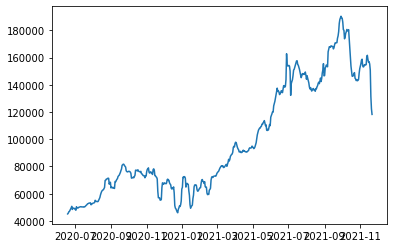

In [46]:
# quick visuals

plt.plot(ridership.date, ridership.ravg_rail)

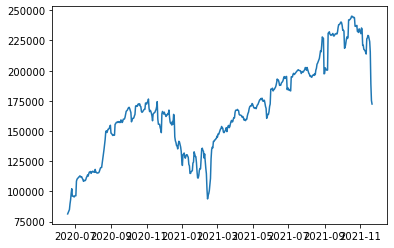

In [47]:
# quick visuals

plt.plot(ridership.date, ridership.ravg_bus)

In [49]:
# merge covid data with ridership

data = covid_data.merge(ridership)

data.head()

,date,cases,pct_pop,never,rarely,sometimes,frequently,always,order_code,daily_cases,...,log_14D_avg,log_ravg,pct_chg_log,log_ravg_pct,Rail,Adjusted_Bus,Rail.1,Bus,ravg_rail,ravg_bus
0,2020-06-19,13928,0.013114,107268.161,161433.272,99833.734,197543.346,494920.426,1,66.0,...,9.499339,9.527354,0.528865,0.000638,53000,93000,-0.92,-0.77,45142.857143,81285.714286
1,2020-06-20,14004,0.013186,107268.161,161433.272,99833.734,197543.346,494920.426,1,76.0,...,9.506749,9.532231,0.145662,0.000512,24000,42000,-0.92,-0.81,45714.285714,82428.571429
2,2020-06-21,14079,0.013256,107268.161,161433.272,99833.734,197543.346,494920.426,1,75.0,...,9.513921,9.537102,-0.018464,0.000511,22000,39000,-0.90,-0.77,46714.285714,83714.285714
3,2020-06-22,14141,0.013315,107268.161,161433.272,99833.734,197543.346,494920.426,1,62.0,...,9.520937,9.542077,-0.177347,0.000522,53000,98000,-0.92,-0.76,47000.000000,84857.142857
4,2020-06-23,14204,0.013374,107268.161,161433.272,99833.734,197543.346,494920.426,1,63.0,...,9.527440,9.547145,0.011648,0.000531,53000,98000,-0.92,-0.77,47714.285714,89571.428571


In [10]:
# helper function- get masked array

def get_ma(var, order):
    return np.ma.masked_where(data.order_code==order, data[var])

In [11]:
# get variables

x = pd.to_datetime(data.date)

# get masked arrays (for different masking orders)

daily_mask = get_ma('daily_cases', 2)
daily_no_mask = get_ma('daily_cases', 1)
total_mask = get_ma('cases', 2)
total_no_mask = get_ma('cases', 1)
roll7_avg_mask = get_ma('rolling_avg_7', 2)
roll7_avg_no_mask = get_ma('rolling_avg_7', 1)
roll14_avg_mask = get_ma('rolling_avg_14', 2)
roll14_avg_no_mask = get_ma('rolling_avg_14', 1)
bus_mask = get_ma('ravg_bus', 2)
bus_no_mask = get_ma('ravg_bus', 1)
rail_mask = get_ma('ravg_rail', 2)
rail_no_mask = get_ma('ravg_rail', 1)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\stride_tricks.py:256: UserWarning: Warning: converting a masked element to nan.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


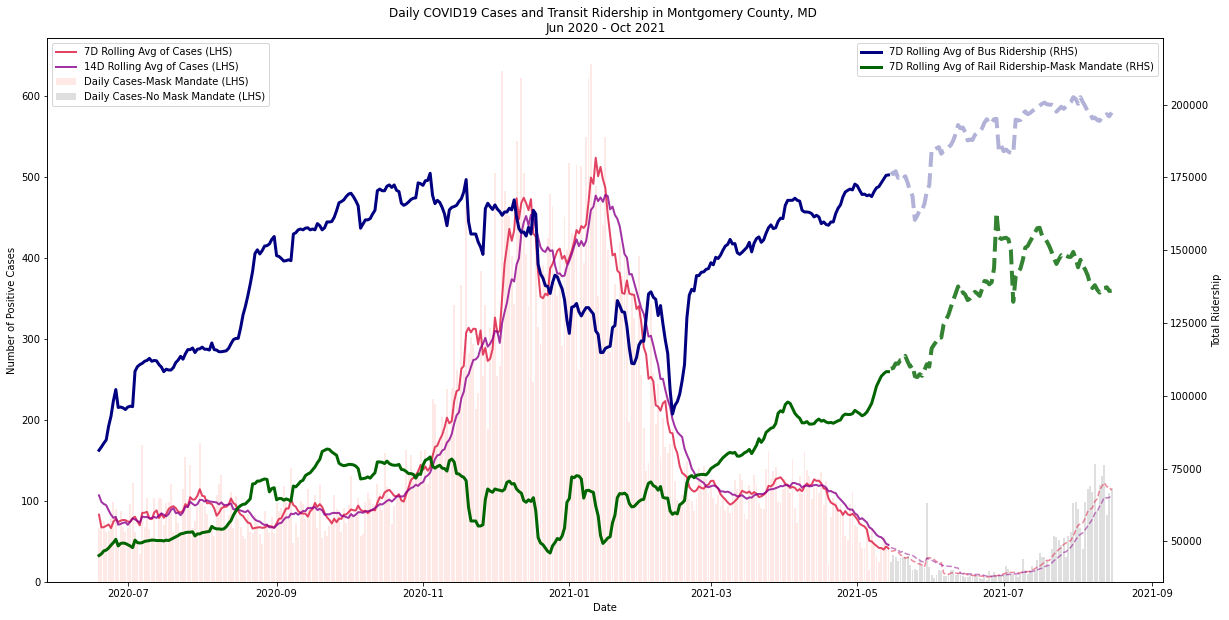

In [63]:
# plot merged df

fig = plt.figure(figsize=(20, 10), facecolor='white')
ax = fig.add_subplot()

ax.set_title('Daily COVID19 Cases and Transit Ridership in Montgomery County, MD \nJun 2020 - Oct 2021')


# plot daily cases
ax.bar(x, daily_mask, alpha=0.8, linewidth=2, color='mistyrose',
        label='Daily Cases-Mask Mandate (LHS)')
ax.bar(x, daily_no_mask, alpha=0.5, color='silver', label='Daily Cases-No Mask Mandate (LHS)')

# plot rolling avg 7D
ax.plot(x, roll7_avg_mask, alpha=0.8, linewidth=2, color='crimson', 
        label='7D Rolling Avg of Cases (LHS)')
ax.plot(x, roll7_avg_no_mask, alpha=0.5, color='crimson', linestyle='dashed')

# plot rolling avg 14D
ax.plot(x, roll14_avg_mask, alpha=0.8, linewidth=2, color='darkmagenta', 
        label='14D Rolling Avg of Cases (LHS)')
ax.plot(x, roll14_avg_no_mask, alpha=0.5, color='darkmagenta', linestyle='dashed')

# set labels
ax.set_xlabel('Date')
ax.set_ylabel('Number of Positive Cases')
plt.legend(loc='upper left')

# plot ridership
ax2 = ax.twinx()
ax2.plot(x, bus_mask, c='navy', linewidth=3, label='7D Rolling Avg of Bus Ridership (RHS)')
ax2.plot(x, bus_no_mask, c='navy', alpha=0.3, linestyle = 'dashed', linewidth=4)

ax2.plot(x, rail_mask, c='darkgreen', linewidth=3, label='7D Rolling Avg of Rail Ridership-Mask Mandate (RHS)')
ax2.plot(x, rail_no_mask, c='darkgreen', alpha=0.8, linestyle = 'dashed', linewidth=4)
ax2.set_ylabel('Total Ridership')
ax2.set_ylim([min(data.ravg_bus.min(), data.ravg_rail.min())*0.8, max(data.ravg_bus.max(), data.ravg_rail.max())*1.1])

plt.legend(loc='upper right')

plt.savefig('visualization/plot_ridership.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [51]:
# load crash data

crashes = pd.read_csv('data_raw/mont_county_crash.csv')

In [53]:
# schema?

for col in crashes.columns:
    print('Data type of {} is {}'.format(col, type(crashes[col][0])))

Data type of Report Number is <class 'str'>
Data type of Local Case Number is <class 'str'>
Data type of Agency Name is <class 'str'>
Data type of ACRS Report Type is <class 'str'>
Data type of Crash Date/Time is <class 'str'>
Data type of Hit/Run is <class 'str'>
Data type of Route Type is <class 'float'>
Data type of Mile Point is <class 'numpy.float64'>
Data type of Mile Point Direction is <class 'float'>
Data type of Lane Direction is <class 'float'>
Data type of Lane Number is <class 'numpy.int64'>
Data type of Lane Type is <class 'float'>
Data type of Number of Lanes is <class 'numpy.int64'>
Data type of Direction is <class 'float'>
Data type of Distance is <class 'numpy.float64'>
Data type of Distance Unit is <class 'float'>
Data type of Road Grade is <class 'float'>
Data type of NonTraffic is <class 'str'>
Data type of Road Name is <class 'float'>
Data type of Cross-Street Type is <class 'float'>
Data type of Cross-Street Name is <class 'float'>
Data type of Off-Road Descriptio

In [52]:
# change to datetime

crashes['date'] = pd.to_datetime(crashes['Crash Date/Time'])

In [54]:
# inspect crash df

print('crashes.shape: ', crashes.shape)
print('crashes.date.min: ', crashes.date.min())
print('crashes.date.max: ', crashes.date.max())

crashes.shape:  (74778, 45)
crashes.date.min:  2015-01-01 00:30:00
crashes.date.max:  2021-11-03 18:59:00


In [55]:
# map severity

sev = {'Property Damage Crash':0,
      'Injury Crash':1,
      'Fatal Crash':2}

In [56]:
# get just relevant features

keep_cols = ['date', 'Latitude', 'Longitude', 
             'Hit/Run', 
             'Weather', 'Road Grade', 'NonTraffic', 'Collision Type', 'Road Condition',
            'Number of Lanes', 'Surface Condition', 'ACRS Report Type']

crash_data = crashes[keep_cols].copy().reset_index()

In [58]:
# pivot and get feature cols

df_temp = pd.pivot_table(crash_data, values='date', index='index', columns='ACRS Report Type', aggfunc='count').reset_index()

crash_data['fatal'] = df_temp['Fatal Crash'].fillna(0)
crash_data['injury'] = df_temp['Injury Crash'].fillna(0)
crash_data['pdo'] = df_temp['Property Damage Crash'].fillna(0)

In [59]:
# get aggregates

crash_agg = crash_data.groupby(crash_data.date.dt.date).sum()[['fatal', 'injury', 'pdo']].reset_index()
crash_agg['total'] = crash_agg.fatal + crash_agg.injury + crash_agg.pdo
crash_agg['total_crash_7d'] = (crash_agg.fatal + crash_agg.injury + crash_agg.pdo).rolling(7).mean()
crash_agg['total_crash_14d'] = (crash_agg.fatal + crash_agg.injury + crash_agg.pdo).rolling(14).mean()
crash_agg['date'] = pd.to_datetime(crash_agg.date)

data2 = data.merge(crash_agg)

print('data2.date.min: ', data2.date.min())
print('data2.date.max: ', data2.date.max())

data2.date.min:  2020-06-19 00:00:00
data2.date.max:  2021-08-15 00:00:00


In [60]:
# get np arrays

pdo = np.array(data2.pdo)
injury = np.array(data2.injury)
fatal = np.array(data2.fatal)
total_7d = np.array(data2.total_crash_7d)
total_14d = np.array(data2.total_crash_14d)

In [31]:
# helper function- get masked array

def get_ma2(var, order):
    return np.ma.masked_where(data2.order_code==order, data2[var])

In [32]:
#get new variables

x_new = pd.to_datetime(data2.date)

# get masked arrays (for different masking orders)

roll7_avg_mask2 = get_ma2('rolling_avg_7', 2)
roll7_avg_no_mask2 = get_ma2('rolling_avg_7', 1)
roll14_avg_mask2 = get_ma2('rolling_avg_14', 2)
roll14_avg_no_mask2 = get_ma2('rolling_avg_14', 1)

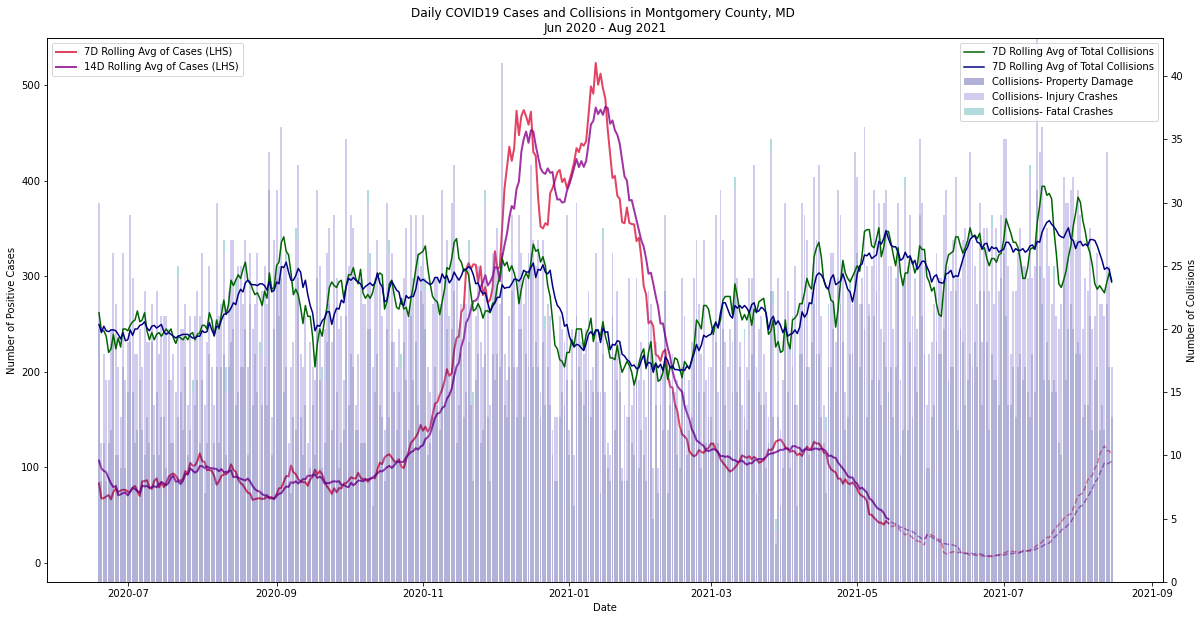

In [62]:
# plot crash df

fig = plt.figure(figsize=(20, 10), facecolor='white')
ax = fig.add_subplot()

ax.set_title('Daily COVID19 Cases and Collisions in Montgomery County, MD \nJun 2020 - Aug 2021')


# plot daily cases
#ax.bar(x, daily_mask, alpha=0.8, linewidth=2, color='mistyrose',
#        label='Daily Cases-Mask Mandate (LHS)')
#ax.bar(x, daily_no_mask, alpha=0.5, color='silver', label='Daily Cases-No Mask Mandate (LHS)')

# plot rolling avg 7D
ax.plot(x_new, roll7_avg_mask2, alpha=0.8, linewidth=2, color='crimson', 
        label='7D Rolling Avg of Cases (LHS)')
ax.plot(x_new, roll7_avg_no_mask2, alpha=0.5, color='crimson', linestyle='dashed')

# plot rolling avg 14D
ax.plot(x_new, roll14_avg_mask2, alpha=0.8, linewidth=2, color='darkmagenta', 
        label='14D Rolling Avg of Cases (LHS)')
ax.plot(x_new, roll14_avg_no_mask2, alpha=0.5, color='darkmagenta', linestyle='dashed')

# set labels
ax.set_xlabel('Date')
ax.set_ylabel('Number of Positive Cases')
plt.legend(loc='upper left')

# plot crashes
ax2 = ax.twinx()
ax2.bar(x_new, pdo, color='navy', linewidth=2, alpha=0.3, label='Collisions- Property Damage')
ax2.bar(x_new, injury, color='slateblue', linewidth=2, alpha=0.3, bottom=pdo, label='Collisions- Injury Crashes')
ax2.bar(x_new, fatal, color='darkcyan', linewidth=2, alpha=0.3, bottom=pdo+injury, label='Collisions- Fatal Crashes')
ax2.plot(x_new, total_7d, c='darkgreen', label='7D Rolling Avg of Total Collisions')
ax2.plot(x_new, total_14d, c='navy', label='7D Rolling Avg of Total Collisions')


ax2.set_ylabel('Number of Collisions')

plt.legend(loc='upper right')

plt.savefig('visualization/plot_crash.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [69]:
# preprocess here for R - ridership
transit = data[['date','cases', 'Rail', 'Adjusted_Bus', 'rolling_avg_14', 'ravg_rail', 'ravg_bus', 'log_ravg_pct']].copy()

transit['all_modes'] = transit.Rail + transit.Adjusted_Bus
transit['all_pct'] = transit.all_modes.pct_change()
transit['ravg_all'] = transit.all_modes.rolling(7).mean()
transit['ravg_all_pct'] = transit.ravg_all.pct_change()

transit['cases_pct'] = transit.cases.pct_change()
transit['rail_pct'] = transit.Rail.pct_change()
transit['bus_pct'] = transit.Adjusted_Bus.pct_change()

transit['ravg_cases_pct'] = transit.rolling_avg_14.pct_change()
transit['ravg_rail_pct'] = transit.ravg_rail.pct_change()
transit['ravg_bus_pct'] = transit.ravg_bus.pct_change()

In [70]:
# preprocess here for R- crash

crash = data2[['date', 'cases', 'total']].copy()
crash['ravg_crash'] = crash.total.rolling(7).mean()

crash['crash_pct'] = crash.total.pct_change()
crash['ravg_crash_pct'] = crash.ravg_crash.pct_change()
crash['cases_pct'] = crash.cases.pct_change()

In [71]:
# export to csv

transit.to_csv('data_clean/transit_data.csv', index=False)
crash.to_csv('data_clean/crashes_data.csv', index=False)